# Adam Trentowski - 162602 - Machine Learning
## lab_10
## Library Imports

In [45]:
# Load the dependencies

import numpy as np
import pandas as pd
import os

# Import sklearn classes

from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# sklearn utility to compare algorithms
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss

# Visualisation Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

import warnings
warnings.filterwarnings('ignore')

from eli5 import explain_weights, show_weights
from yellowbrick import ROCAUC
from yellowbrick.classifier import ClassificationReport

CV_N_REPEATS = 5
BINS = 10

## Data Loading

In [2]:
df = pd.read_csv('VLagun_Chem_Years3.csv')
df.head()

,SRP,DOP,PP,NH4N,NO3N,DON,PN,TN/TP,Fe,SiO4Si,DINtoDIP,Years
0,3.5,11.7,185.0,0.039,0.022,0.551,0.759,6.848152,0.0121,2.3112,17.428571,0
1,4.4,17.5,111.3,0.020,0.025,0.123,1.181,10.127628,0.0136,2.1157,10.227273,0
2,3.2,22.8,103.4,0.016,0.008,0.582,0.576,9.134467,0.0368,2.2641,7.500000,0
3,4.3,22.3,92.7,0.026,0.021,0.693,0.689,11.978206,0.0172,2.2623,10.930233,0
4,11.7,30.3,73.2,0.022,0.048,0.383,1.006,12.664931,0.0237,2.2164,5.982906,0


In [3]:
print(f'Shape of dataset {df.shape}')

Shape of dataset (120, 12)


## Elementary Data Analysis (EDA)

Text(0, 0.5, 'Years')

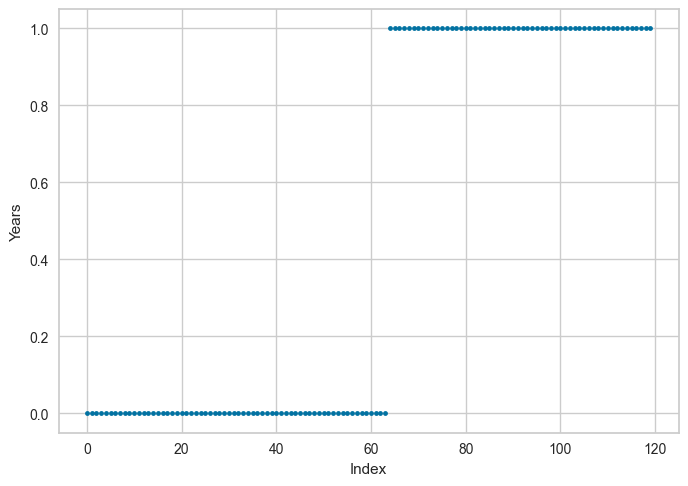

In [5]:
plt.figure()
plt.plot(df.Years, '.')
plt.xlabel('Index')
plt.ylabel('Years')

Text(0.5, 1.0, 'Seaborn countplot of Years within dataset')

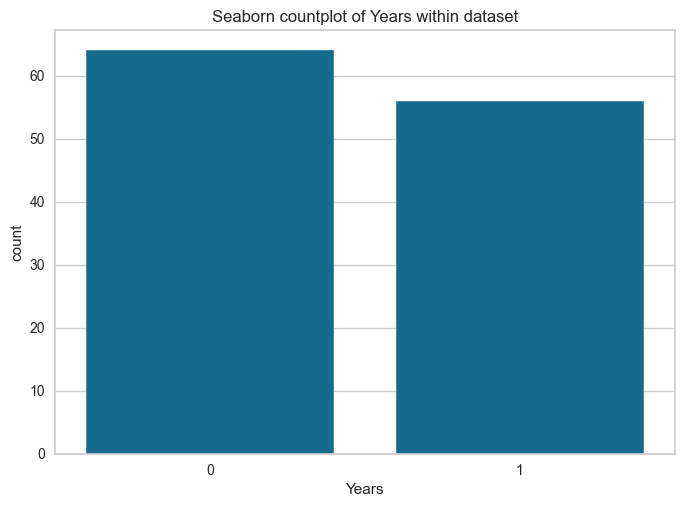

In [6]:
plt.figure()
ax = sns.countplot(data=df, x='Years')
ax.set_title("Seaborn countplot of Years within dataset")

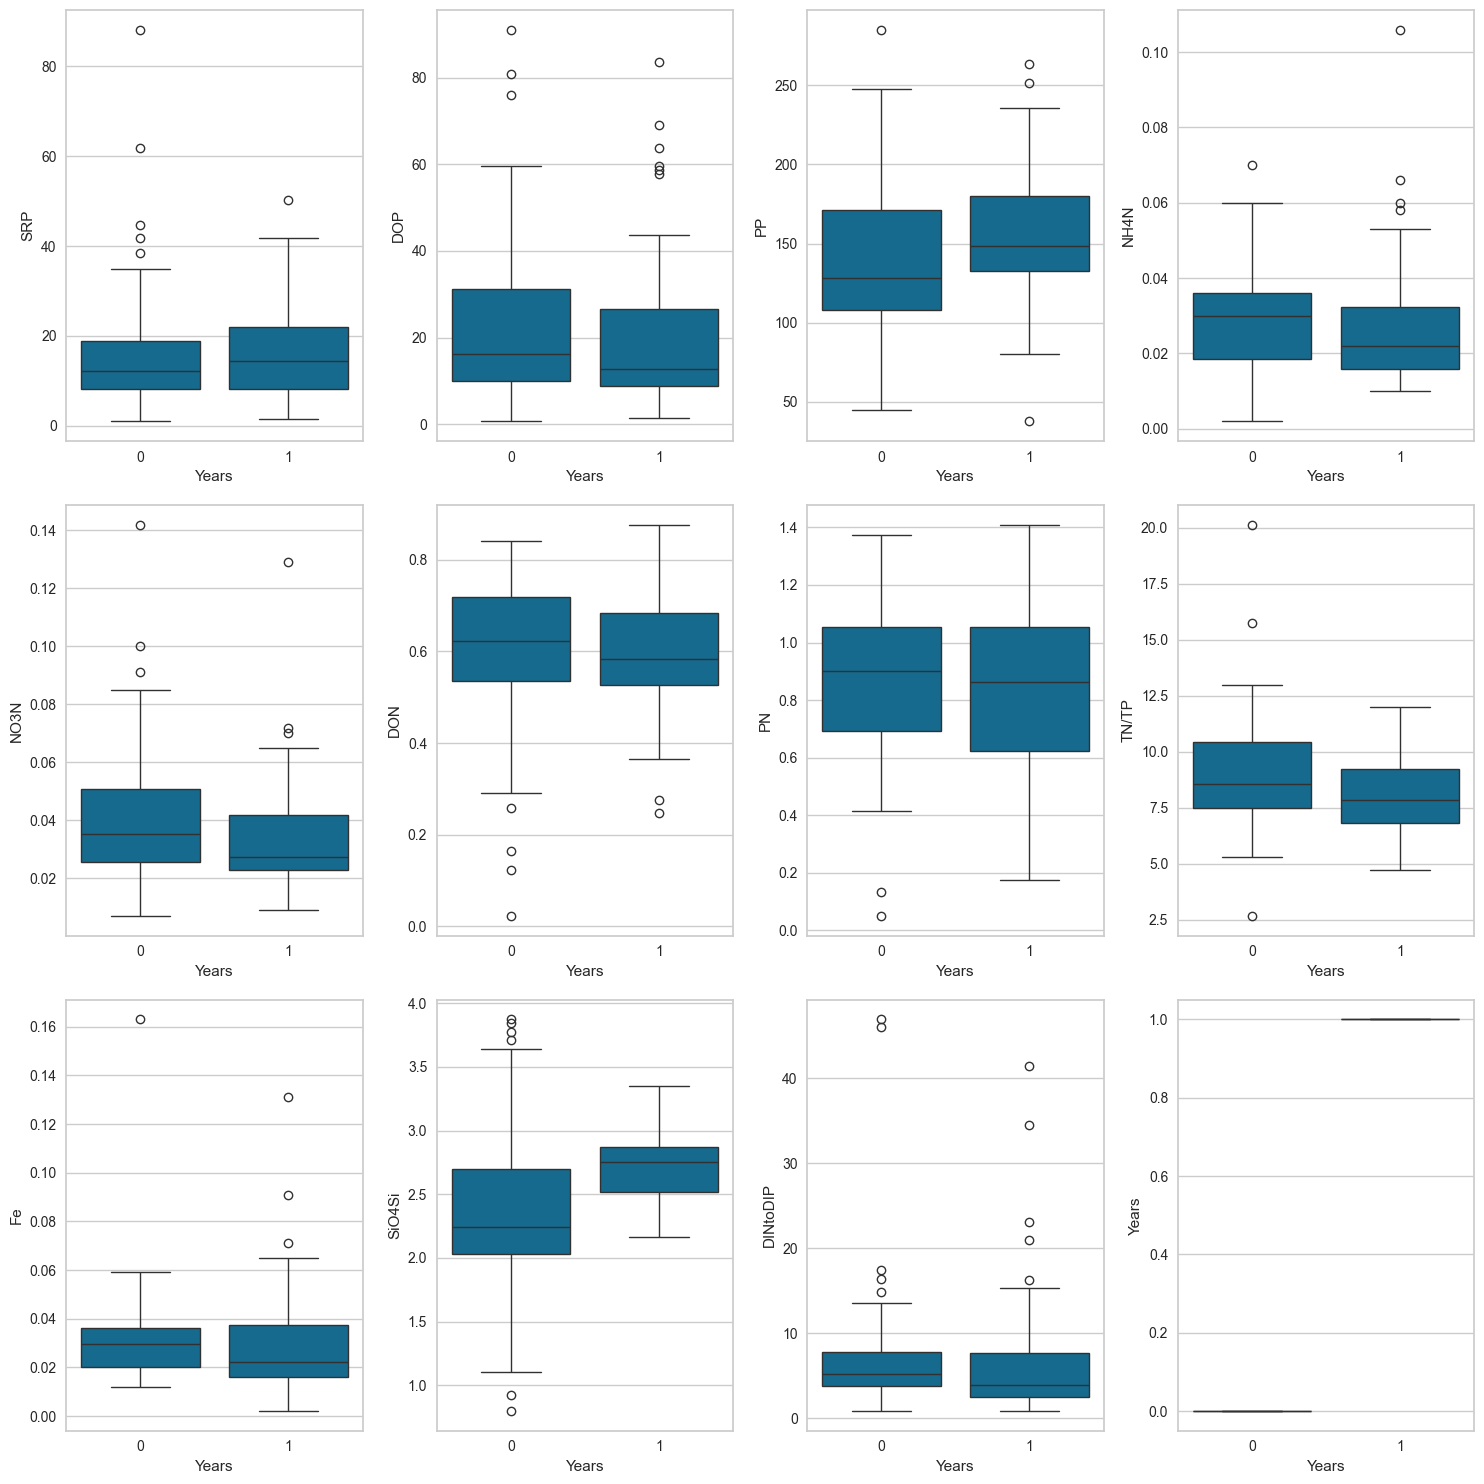

In [8]:
columns = df.columns

f, axes = plt.subplots(3, 4, figsize=(15, 15))
sns.set(style="white", palette="Set3", color_codes=True)

for i, col in enumerate(columns):
    row = i // 4
    col_idx = i % 4
    sns.boxplot(y=col, x="Years", data=df, orient='v', ax=axes[row, col_idx])

f.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9, hspace=0.4, wspace=0.3)
plt.tight_layout()
plt.show()

In [11]:
df_copy = df.copy(deep=True)
cols_to_replace = ['SRP', 'DOP', 'PP', 'NH4N', 'NO3N', 'DON', 'PN', 'TN/TP', 'Fe',
       'SiO4Si', 'DINtoDIP']
df_copy[cols_to_replace] = df_copy[cols_to_replace].replace(0, np.nan)

print('Number of zero entries in each attribute:\n')
print(df_copy.isnull().sum())

Number of zero entries in each attribute:

SRP         0
DOP         0
PP          0
NH4N        0
NO3N        0
DON         0
PN          0
TN/TP       0
Fe          0
SiO4Si      0
DINtoDIP    0
Years       0
dtype: int64


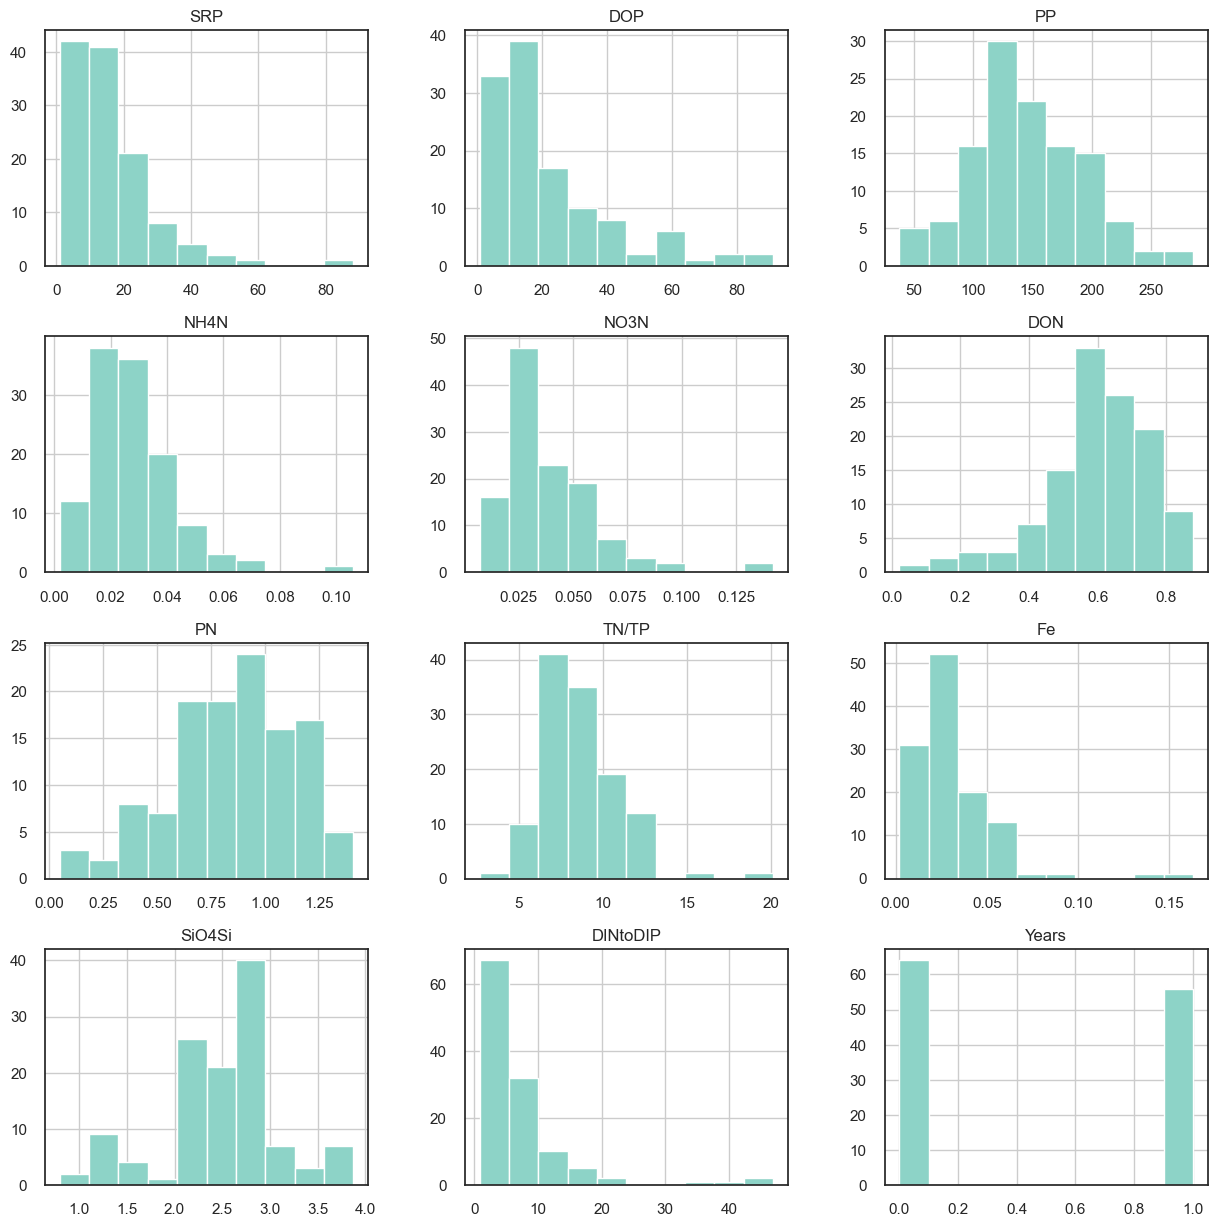

In [12]:
p = df.hist(figsize=(15, 15))

In [13]:
print('Imputing NaN values')

for col in cols_to_replace:
    df_copy[col].fillna(df_copy[col].mean(), inplace=True)

print('Number of zero entries in each attribute:\n')
print(df_copy.isnull().sum())

Imputing NaN values
Number of zero entries in each attribute:

SRP         0
DOP         0
PP          0
NH4N        0
NO3N        0
DON         0
PN          0
TN/TP       0
Fe          0
SiO4Si      0
DINtoDIP    0
Years       0
dtype: int64


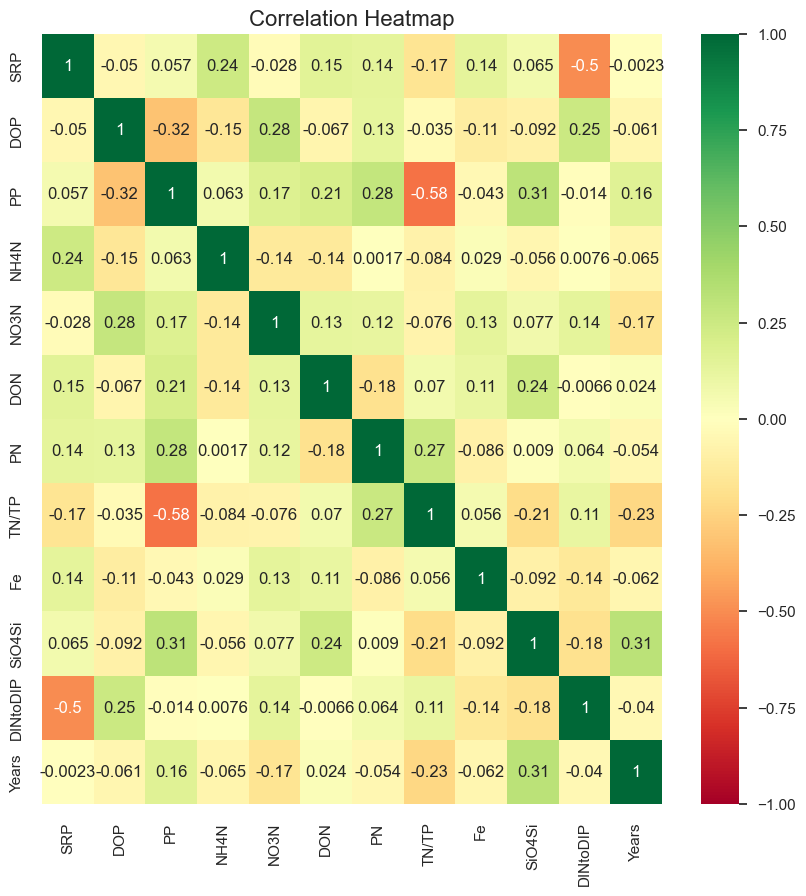

In [14]:
plt.figure(figsize=(10, 10))
corr = df_copy.corr()
corr.index = df_copy.columns
sns.heatmap(corr, annot=True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

<Figure size 800x550 with 0 Axes>

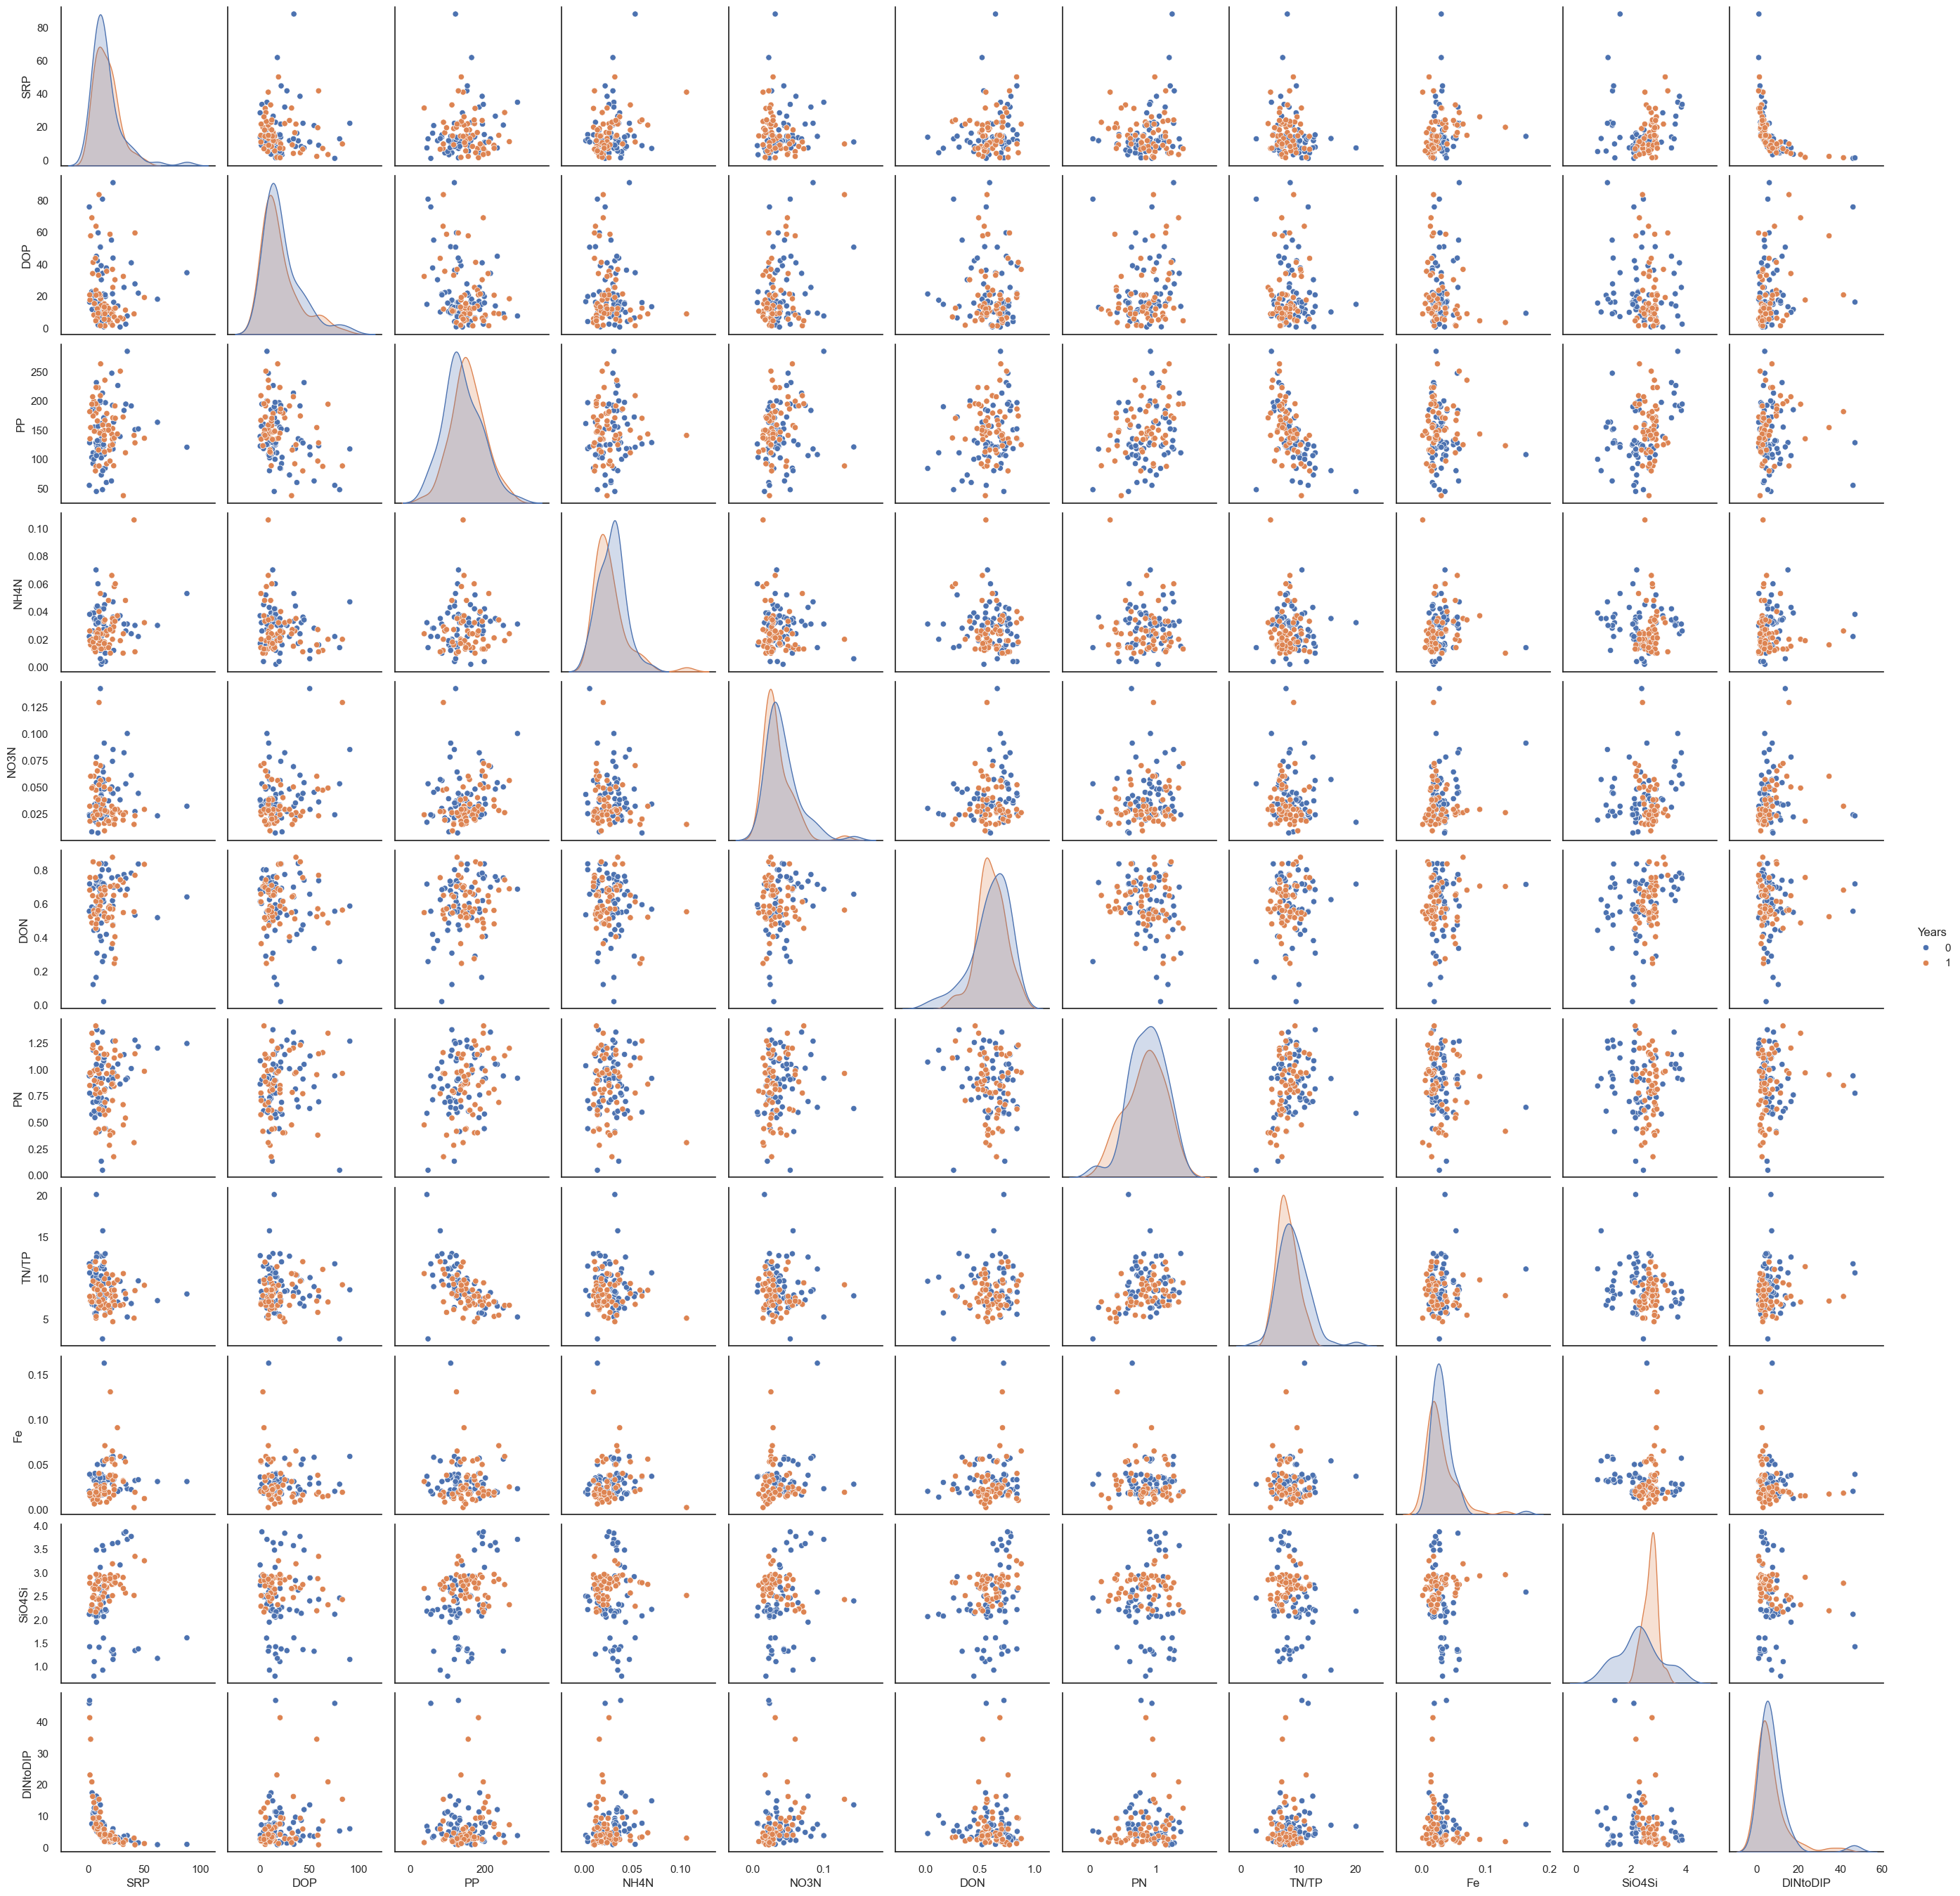

In [15]:
plt.figure()
sns.pairplot(data=df_copy, hue='Years', diag_kind='kde', palette='deep')

## Principal Component Analysis (PCA)

In [18]:
# Separating the features and the target (Y)
X = df_copy.iloc[:, :11]
Y = df_copy.iloc[:, 11]

# Standardizing the features
X = StandardScaler().fit_transform(X)

# Fit PCA and transform X
pca = PCA(n_components=0.90)
pca.fit(X)

print('Variance explained by the principal components (in decreasing order):', pca.explained_variance_ratio_)

X1 = pca.transform(X)
print('Shape of transformed X:', X1.shape)

Variance explained by the principal components (in decreasing order): [0.18895058 0.1495043  0.12268902 0.11774918 0.10197341 0.09548722
 0.07926256 0.06260638]
Shape of transformed X: (120, 8)


## Data Loading

In [19]:
df = pd.read_csv('VLagun_Chem_Years3.csv')
X = df.iloc[:, 0:11].values
Y = df.iloc[:, 11].values

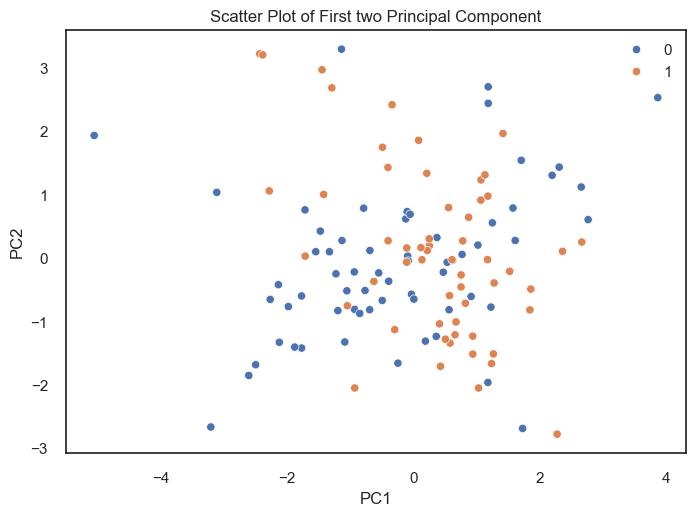

In [22]:
plt.figure()
sns.scatterplot(x=X1[:, 0], y=X1[:, 1], hue=Y, palette='deep')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter Plot of First two Principal Component')
plt.show()

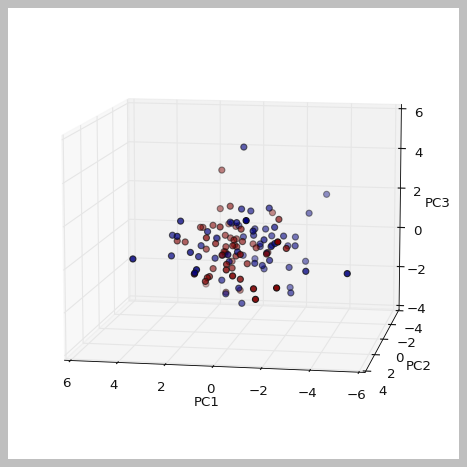

In [24]:
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('classic')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X1[:, 0], X1[:, 1], X1[:, 2], c=df.Years, s=30)
ax.view_init(10, 100)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.tight_layout()
plt.show()

## Model Building

In [25]:
seed = 7
test_size = 0.20

X = df_copy.iloc[:, :-1]
Y = df_copy.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (96, 11)
Shape of X_test: (24, 11)


In [26]:
dum = DummyClassifier(strategy='most_frequent')
dum = dum.fit(X_train, y_train)

score = dum.score(X_test, y_test)
print("Dummy Classifier Accuracy: %.2f%%" % (score * 100.0))

Dummy Classifier Accuracy: 45.83%


<Figure size 560x560 with 0 Axes>

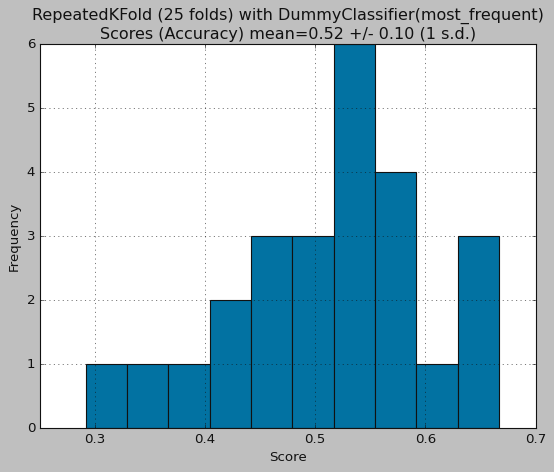

In [27]:
strategy = "most_frequent"

scores = cross_val_score(dum, X, Y,
                         cv=RepeatedKFold(n_repeats=CV_N_REPEATS),
                         scoring=None)
scores_dummy = scores.copy()

score_line = "Scores (Accuracy) mean={0:.2f} +/- {1:.2f} (1 s.d.)".format(scores.mean(), scores.std())

plt.figure(figsize=(7,7))
fig, ax = plt.subplots()
pd.Series(scores).hist(ax=ax, bins=BINS)
ax.set_title(f"RepeatedKFold ({len(scores)} folds) with DummyClassifier({strategy})\n" + score_line)
ax.set_xlabel("Score")
ax.set_ylabel("Frequency")
plt.show()

## Helper Functions

In [28]:
def plot_tree_graph(model, columns, class_names):
    dot_data = export_graphviz(model, feature_names=columns, class_names=class_names)
    graph = graphviz.Source(dot_data)
    return graph

In [29]:
def confusion_mat(y_pred, y_test):
    plt.figure()
    sns.set(font_scale=1.5)
    cm = confusion_matrix(y_pred, y_test)
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

## K-Nearest Neighbors

In [30]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train)

scores = cross_val_score(knn, X, Y, cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))
print(f"Accuracy mean={scores.mean():0.2f} +/- {scores.std():0.2f} (1 s.d.)")

Accuracy mean=0.57 +/- 0.08 (1 s.d.)


## Decision tree

In [31]:
dt = DecisionTreeClassifier(random_state=1, max_depth=2)
dt = dt.fit(X_train, y_train)
dt_scores = cross_val_score(dt, X, Y, cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))
print(f"Accuracy mean={dt_scores.mean():0.2f} +/- {dt_scores.std():0.2f} (1 s.d.)")

Accuracy mean=0.73 +/- 0.07 (1 s.d.)


## Plot decision tree to visualize the splitting rules

In [33]:
plt.figure()
graph = plot_tree_graph(dt, X.columns, class_names=['0', '1'])
graph

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

<Figure size 640x480 with 0 Axes>

## Bagging Classifier

In [34]:
bag = BaggingClassifier(n_estimators=100, oob_score=True)
bag = bag.fit(X_train, y_train)

bag_scores = cross_val_score(bag, X, Y, cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))
print("Accuracy mean={0:0.2f} +/- {1:0.2f} (1 s.d.)".format(bag_scores.mean(), bag_scores.std()))
print("Out of bag score: {0:0.2f}".format(bag.oob_score_ * 100))

Accuracy mean=0.80 +/- 0.08 (1 s.d.)
Out of bag score: 76.04


## Random Forest

Accuracy of Random Forest Classifier: 83.33


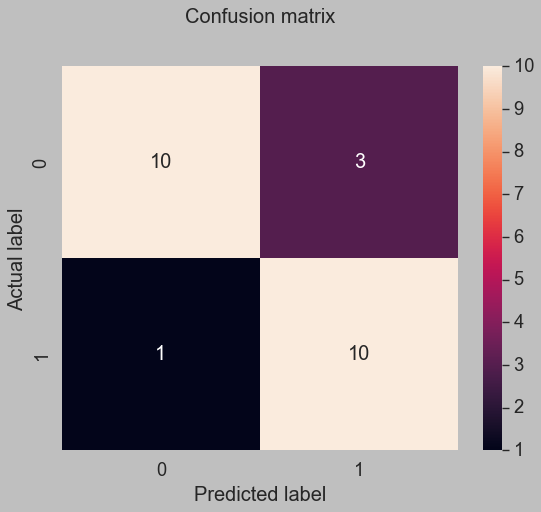

In [35]:
num_estimators = 100
rf = RandomForestClassifier(n_estimators=num_estimators)
rf.fit(X_train, y_train)

rf_score = rf.score(X_test, y_test)
print("Accuracy of Random Forest Classifier: {0:0.2f}".format(rf_score * 100.0))

y_pred = rf.predict(X_test)
confusion_mat(y_pred, y_test)

In [36]:
feture_names = X_train.columns.values
show_weights(rf, feature_names=feture_names)

Weight,Feature
0.1957 ± 0.3411,SiO4Si
0.1101 ± 0.2033,NH4N
0.1079 ± 0.1992,DINtoDIP
0.1061 ± 0.1668,NO3N
0.0829 ± 0.1545,PP
0.0769 ± 0.1578,TN/TP
0.0754 ± 0.1703,SRP
0.0666 ± 0.1449,Fe
0.0661 ± 0.1355,DOP
0.0600 ± 0.1162,DON


## Check variance in RF prediction quality

Scores mean=0.82 +/- 0.07 (1 s.d.)


Text(0, 0.5, 'Frequency')

<Figure size 640x480 with 0 Axes>

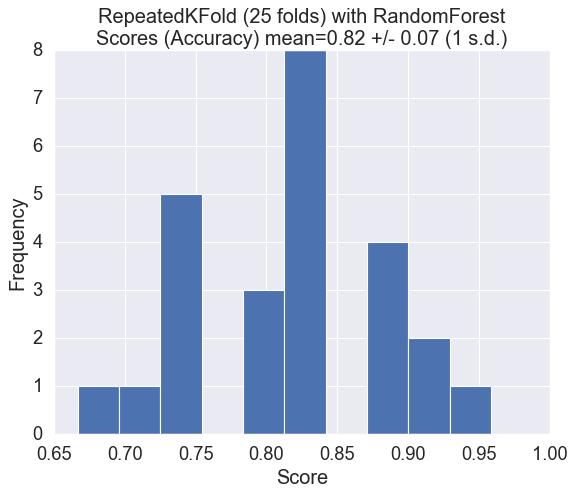

In [38]:
scores = cross_val_score(rf, X, Y, cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))
scores_est = scores.copy()

print(f"Scores mean={scores.mean():0.2f} +/- {scores.std():0.2f} (1 s.d.)")

score_line = f"Scores (Accuracy) mean={scores.mean():0.2f} +/- {scores.std():0.2f} (1 s.d.)"

plt.figure()
fig, ax = plt.subplots()
pd.Series(scores).hist(ax=ax, bins=BINS)
ax.set_title(f"RepeatedKFold ({len(scores)} folds) with RandomForest\n" + score_line)
ax.set_xlabel("Score")
ax.set_ylabel("Frequency")

## Comparing the prediction performance of random forest classifier against the Dummy classifier

Text(0.5, 1.0, 'Dummy vs RandomForest Scores')

<Figure size 640x480 with 0 Axes>

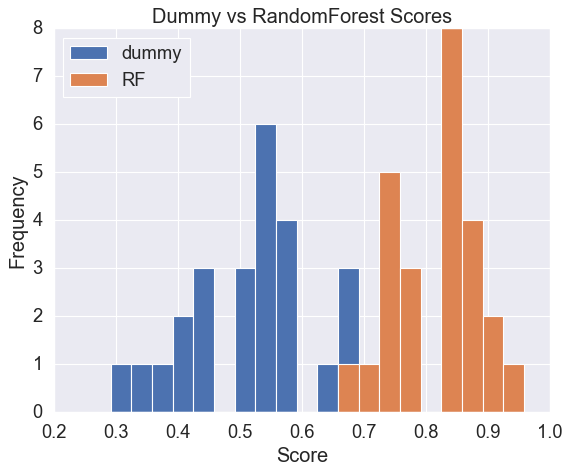

In [39]:
plt.figure()
fig, ax = plt.subplots()
df_dummy_est_scores = pd.DataFrame({'dummy': scores_dummy, 'RF': scores_est})
df_dummy_est_scores.plot(kind='hist', ax=ax, bins=20)
ax.set_xlabel("Score")
ax.set_title("Dummy vs RandomForest Scores")

## GradientBoostingClassifier (Sklearn)

In [42]:
params = {'n_estimators': 500, 'learning_rate': 0.01, 'max_depth': 4, 'loss': 'log_loss'}
gbm = GradientBoostingClassifier(**params)
gbm.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=500)

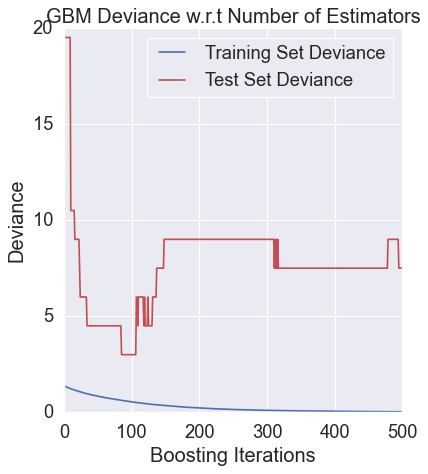

In [46]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(gbm.staged_predict(X_test)):
    test_score[i] = log_loss(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('GBM Deviance w.r.t Number of Estimators')
plt.plot(np.arange(params['n_estimators']) + 1, gbm.train_score_, 'b-', label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-', label='Test Set Deviance')
plt.legend(loc='best')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.show()

Accuracy of GBM Classifier: 91.67


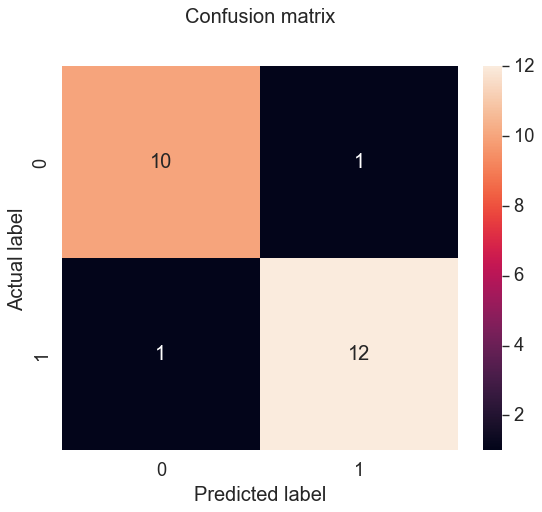

In [47]:
params = {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 4, 'loss': 'log_loss'}
gbm = GradientBoostingClassifier(**params)
gbm.fit(X_train, y_train)

y_pred = gbm.predict(X_test)
gbm_score = accuracy_score(y_test, y_pred)
print("Accuracy of GBM Classifier: {0:0.2f}".format(gbm_score * 100.0))

confusion_mat(y_pred, y_test)

## Plot Feature Importance for the GBM model

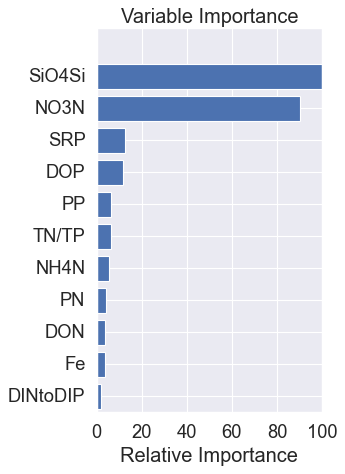

In [48]:
feature_importance = gbm.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## XGBoost

In [49]:
from xgboost import XGBClassifier, plot_importance, to_graphviz

param = {'max_depth': 3, 'eta': 0.8, 'subsample': 1, 'objective': 'binary:logistic'}
xgb = XGBClassifier(**param)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.8, eval_metric=None,
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

Accuracy of XGBoost Classifier: 75.00


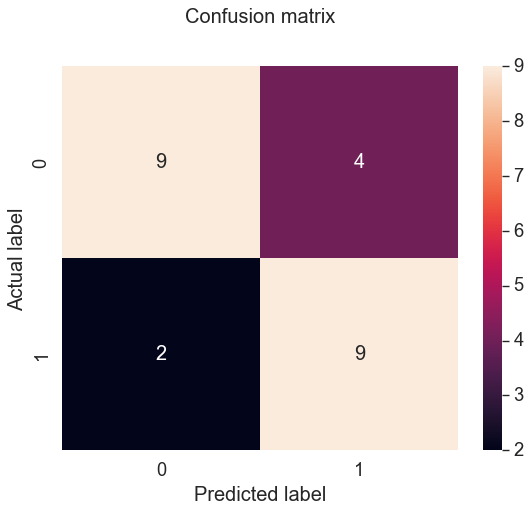

In [50]:
y_pred = xgb.predict(X_test)
xgb_score = accuracy_score(y_test, y_pred)
print("Accuracy of XGBoost Classifier: {0:0.2f}".format(xgb_score * 100.0))

confusion_mat(y_pred, y_test)

## Stacking

In [51]:
from mlxtend.classifier import StackingCVClassifier

sclf = StackingCVClassifier(classifiers=[knn, rf, gbm, xgb], meta_classifier=rf)

print('10-fold cross validation:\n')

10-fold cross validation:



In [52]:
for clf, label in zip([knn, rf, xgb, gbm, rf],
                      ['KNearest Neighbors',
                       'Random Forest',
                       'XGB', 'GBM',
                       'MetaClassifier']):
    sclf_scores = model_selection.cross_val_score(clf, X, Y,
                                                  cv=10,
                                                  scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (sclf_scores.mean(), sclf_scores.std(), label))

Accuracy: 0.55 (+/- 0.15) [KNearest Neighbors]
Accuracy: 0.78 (+/- 0.15) [Random Forest]
Accuracy: 0.78 (+/- 0.17) [XGB]
Accuracy: 0.69 (+/- 0.13) [GBM]
Accuracy: 0.78 (+/- 0.18) [MetaClassifier]


## Summarize results

In [54]:
from sklearn.ensemble import VotingClassifier

models = []
models.append(('KNN', knn))
models.append(('DT', dt))
models.append(('RF', rf))
models.append(('GBM', gbm))
models.append(('XGB', xgb))
# models.append(('Voting', ensemble_knn_rf_xgb))

ensemble_knn_rf_xgb = VotingClassifier(
    estimators=[
        ('KNN', knn),
        ('RF', rf),
        ('XGB', xgb)
    ],
    voting='soft'
)

models.append(('Voting', ensemble_knn_rf_xgb))

In [56]:
results = []
names = []

for name, model in models:
    kfold = model_selection.StratifiedKFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "{}: {} ({})".format(name, cv_results.mean(), cv_results.std())
    print(msg)

results.append(np.asarray(sclf_scores))
names.append('Stacking')

KNN: 0.55 (0.1452966314513558)
DT: 0.7083333333333333 (0.1717960677340692)
RF: 0.7749999999999999 (0.14930394055974094)
GBM: 0.6916666666666667 (0.12936812246883353)
XGB: 0.775 (0.175)
Voting: 0.7999999999999999 (0.17159383568311667)


## Boxplot algorithm comparison

In [64]:
df_results = pd.DataFrame({
    'Accuracy': np.concatenate(results),
    'Classifier': np.repeat(names, [len(r) for r in results])
})

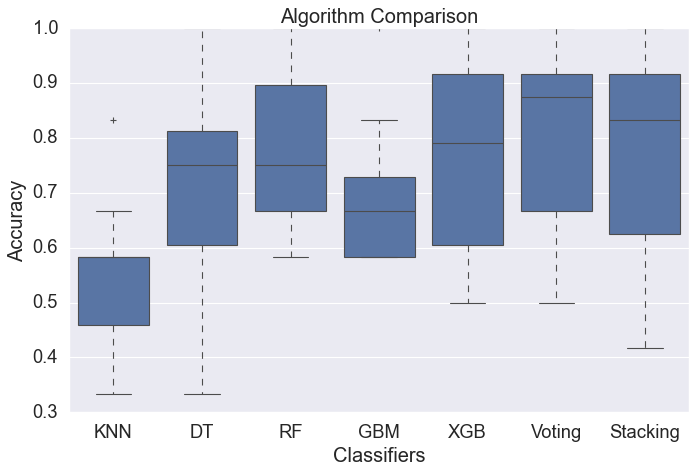

In [66]:
plt.figure(figsize=(10, 6))
plt.title('Algorithm Comparison')
sns.boxplot(x='Classifier', y='Accuracy', data=df_results)
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.show()

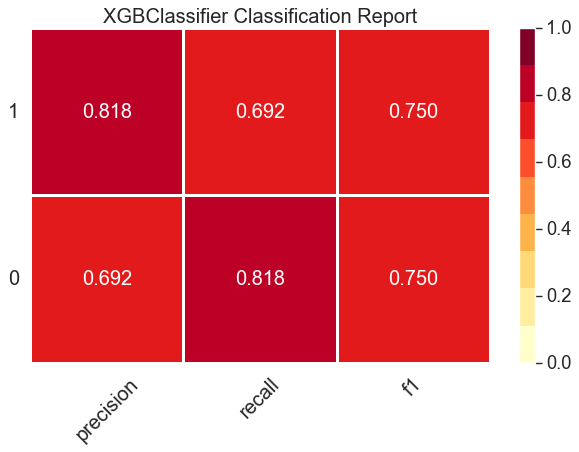

<Axes: title={'center': 'XGBClassifier Classification Report'}>

In [67]:
visualizer = ClassificationReport(xgb, classes=['0', '1'])

# visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

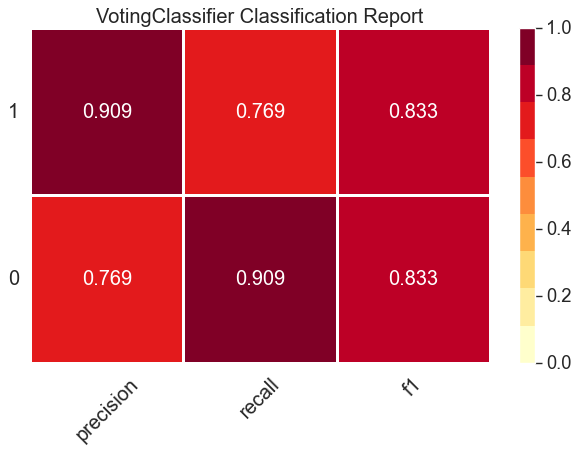

<Axes: title={'center': 'VotingClassifier Classification Report'}>

In [69]:
visualizer = ClassificationReport(ensemble_knn_rf_xgb, classes=['0', '1'])

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()